In [1]:
import warnings
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import ConstantInputWarning
import os, sys
sys.path.insert(0, "../")
from alphalens.utils import get_forward_returns_columns

from factor_cal.config_loader import basic_config as cfg
from factor_cal.table.ddb_table import PriceTable, SecLevelFacTable
from factor_cal.utils import ddb_utils as du
from factor_cal.factor_eval import basic_evaluate as be
from factor_cal.factor_eval.basic_evaluate import get_clean_data, factor_portfolio_return,\
    factor_information_coefficient, get_factor_ic_summary_info, plot_quantile_info, plot_quantile_netvalue
# igmore the warning of ConstantInputWarning
warnings.filterwarnings("ignore", category=ConstantInputWarning)
# obtain the ddb session
s = du.DDBSessionSingleton().session   

In [2]:
date = '2023.09.22'
base_dirpath = '/home/wangzirui/workspace/data'
factors_df= pd.read_pickle(f'{base_dirpath}/fac_ret_{date}.pkl')
factors_df.set_index(['tradetime', 'securityid'], inplace=True)

In [3]:
config = cfg.BasicConfig('config/config.yml')

stat_date = '2023.09.22'
factor_name = 'ret_v_prod_5min'

In [4]:
sel_cols = factors_df.columns[:3]
sel_cols = np.append(sel_cols, [factor_name])
factor_and_ret = factors_df[sel_cols].copy()
factor_and_ret.rename(columns={factor_name: "factor"}, inplace=True)
factor_and_ret.replace(np.inf, np.nan, inplace=True)

In [9]:
factor_and_ret.index = factor_and_ret.index.rename(['tradetime', 'securityid'])
factor_and_ret

1m        3m        5m    factor  \
tradetime           securityid                                           
2023-09-22 09:31:39 000002.SZ  -0.004522 -0.004522 -0.003768  0.515152   
                    000004.SZ  -0.004899 -0.006124 -0.013472  0.484848   
                    000006.SZ  -0.006522 -0.006522 -0.006522  0.878788   
                    000010.SZ   0.003040  0.009119  0.021277  0.575758   
                    000026.SZ  -0.004363 -0.006981 -0.007853  0.181818   
...                                  ...       ...       ...       ...   
2023-09-22 14:55:00 688798.SH  -0.001882 -0.001882 -0.002027  0.010000   
                    688799.SH  -0.003705 -0.003458 -0.001976  0.020000   
                    688800.SH  -0.000764 -0.001273 -0.001273  0.520000   
                    688819.SH   0.000286  0.001432  0.001146  0.150000   
                    688981.SH   0.000000 -0.001756 -0.000781  0.070000   

                                factor_quantile  
tradetime           securityid                   
2023-09-22 09:31:39 000002.SZ                 3  
                    000004.SZ                 3  
                    000006.SZ                 5  
                    000010.SZ                 4  
                    000026.SZ                 1  
...                                         ...  
2023-09-22 14:55:00 688798.SH                 1  
                    688799.SH                 1  
                    688800.SH                 5  
                    688819.SH                 1  
                    688981.SH                 1  

[23493900 rows x 5 columns]

In [10]:
grouper = ['factor_quantile', 'tradetime']
def src_rough_return(group):
        return group[get_forward_returns_columns(factor_and_ret.columns)].mean()
    
portforlio_group_return = factor_and_ret.groupby(grouper).apply(src_rough_return)
    

In [22]:
np.arange(0, 100, 20)

array([ 0, 20, 40, 60, 80])

In [36]:
def src_port_rough_return(group):
    total_num = len(group)
    
    dict_col_holding_time = {'1m': 20, '3m': 60, '5m': 100}
    values = []
    indices = []
    for col, holding_time in dict_col_holding_time.items():
    
        final_price = 0
        for i in range(holding_time):
            index_list = range(i, total_num, holding_time)
            final_price +=(group.iloc[index_list][col]+1).cumprod().iloc[-1]
        final_price = final_price / holding_time
        values.append(final_price)
        indices.append(col)
    return pd.Series(values, index=indices)

In [40]:
port_rough_return = portforlio_group_return.groupby('factor_quantile').apply(src_port_rough_return)

port_rough_return = port_rough_return - 1
port_rough_return.loc['hedge'] = port_rough_return.loc[1] - port_rough_return.loc[5]
port_rough_return


,1m,3m,5m
factor_quantile,,,
1,-0.235973,-0.096857,-0.044593
2,-0.427962,-0.184690,-0.103787
3,-0.633144,-0.299043,-0.175006
4,-0.526767,-0.234261,-0.134098
5,-0.267541,-0.110547,-0.053816
hedge,0.031568,0.013690,0.009223


In [21]:
portforlio_group_return.loc[1].iloc[np.arange(0, 20, 4)]

,1m,3m,5m
tradetime,,,
2023-09-22 09:31:39,-0.002467,-0.002704,-0.006093
2023-09-22 09:31:51,-0.002836,-0.004385,-0.005211
2023-09-22 09:32:03,-0.003994,-0.004993,-0.005576
2023-09-22 09:32:15,-0.004812,-0.005380,-0.006197
2023-09-22 09:32:27,-0.005171,-0.004563,-0.005536


In [5]:
import evaluate
close = evaluate.get_trade_close_bydate(stat_date, config)
td_ret = evaluate.get_trade_return(close)

In [6]:
factor_and_ret = get_clean_data(factor_and_ret, config['evaluation'])

Dropped 2.1% entries from factor data: 2.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 50.0%, not exceeded: OK!


In [6]:
ic_data = factor_information_coefficient(factor_and_ret)
ic_summary = get_factor_ic_summary_info(ic_data)
base_dirpath = '/home/wangzirui/workspace/factor_eval_summary/top_n'
table_dirpath = f'{base_dirpath}/ICtable'
os.makedirs(table_dirpath, exist_ok=True)
ic_summary.to_csv(f'{table_dirpath}/{factor_name}.csv')

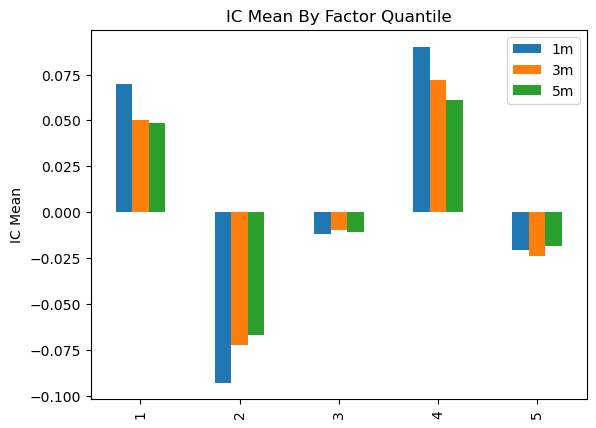

In [8]:
ic_data_bygroup = factor_information_coefficient(factor_and_ret, by_group=True)
ic_summary_bygroup = get_factor_ic_summary_info(ic_data_bygroup, by_group=True)
ic_summary_bygroup.to_csv(f'{table_dirpath}/{factor_name}_group.csv')

plot_dirpath = f'{base_dirpath}/ICplot'
os.makedirs(plot_dirpath, exist_ok=True)
ic_group_filepath = f"{plot_dirpath}/{factor_name}.png"
plot_quantile_info(ic_summary_bygroup.loc['IC Mean'], ic_group_filepath)
    

In [7]:
factor = factor_and_ret[['factor', 'factor_quantile']].copy()

In [8]:
port_metric_summary, port_netvalue_summary = factor_portfolio_return(factor, td_ret, holding_time=20, long_short=True)

In [12]:
factor_data = factor
holding_time = 20
groups = np.sort(factor_data['factor_quantile'].unique())
metric_summary = None
netvalue_summary = None

factor_data['group_size'] = factor_data.groupby(['tradetime', 'factor_quantile'])['factor'].transform(lambda x: len(x))
factor_data['wt'] = 1 / factor_data['group_size'] / holding_time

In [17]:
portforlio_weight = be.form_portforlio_weight(factor_data, 1 , 5, holding_time)
portforlio_weight.head(1)

,,factor,factor_quantile,group_size,wt
tradetime,securityid,,,,
2023-09-22 09:31:39,000026.SZ,0.181818,1,50,0.001


In [19]:
port_weight = portforlio_weight.reset_index()
ret_df = td_ret.reset_index()

In [22]:
last_ts = min(ret_df['tradetime'].max(), port_weight['tradetime'].max())
ages = [pd.Timedelta(i*3, unit='s') for i in np.arange(holding_time+1)]
pos = pd.merge(port_weight, pd.DataFrame({'age': ages}), how='cross')
pos.rename(columns={'tradetime': 'tranche'}, inplace=True)
pos['tradetime'] = pos['age'] + pos['tranche']
pos = pos.drop(pos[pos['tradetime'] > last_ts].index) 

In [ ]:
pos = pos.merge(ret_df, on=['tradetime', 'securityid'], how='left')

In [21]:
pos.head(5)

,tranche,securityid,factor,factor_quantile,group_size,wt,age
0,2023-09-22 09:31:39,000026.SZ,0.181818,1,50,0.001,0 days 00:00:00
1,2023-09-22 09:31:39,000026.SZ,0.181818,1,50,0.001,0 days 00:00:03
2,2023-09-22 09:31:39,000026.SZ,0.181818,1,50,0.001,0 days 00:00:06
3,2023-09-22 09:31:39,000026.SZ,0.181818,1,50,0.001,0 days 00:00:09
4,2023-09-22 09:31:39,000026.SZ,0.181818,1,50,0.001,0 days 00:00:12


In [14]:
portforlio_weight = be.form_portforlio_weight(factor_data, 1, max(groups), holding_time)

NameError: name 'be' is not defined

In [61]:
# factor_and_ret.head(1)
# td_ret.head(1)
factor = factor_and_ret[['factor', 'factor_quantile', 'wt']].copy()
factor.index = factor.index.rename(['tradetime', 'securityid'])
# factor = factor_and_ret
factor['group_size'] = factor.groupby(['tradetime', 'factor_quantile'])['factor'].transform(lambda x: len(x))
holding_time = 20
factor['wt'] = 1/factor['group_size'] / holding_time

In [62]:
portforlio_weight = form_portforlio_weight(factor, 1, 5, holding_time)

In [77]:
port_weight = portforlio_weight[:100000].reset_index()
ret_df = td_ret.reset_index()

In [78]:
port_weight.head(1)

,tradetime,securityid,factor,factor_quantile,wt,group_size
0,2023-09-22 09:31:39,000026.SZ,0.181818,1,0.001,50


In [84]:
last_ts = min(ret_df['tradetime'].max(), port_weight['tradetime'].max())
ages = np.arange(holding_time+1)
ages = [pd.Timedelta(i*3, unit='s') for i in ages]

[Timedelta('0 days 00:00:00'),
 Timedelta('0 days 00:00:03'),
 Timedelta('0 days 00:00:06'),
 Timedelta('0 days 00:00:09'),
 Timedelta('0 days 00:00:12'),
 Timedelta('0 days 00:00:15'),
 Timedelta('0 days 00:00:18'),
 Timedelta('0 days 00:00:21'),
 Timedelta('0 days 00:00:24'),
 Timedelta('0 days 00:00:27'),
 Timedelta('0 days 00:00:30'),
 Timedelta('0 days 00:00:33'),
 Timedelta('0 days 00:00:36'),
 Timedelta('0 days 00:00:39'),
 Timedelta('0 days 00:00:42'),
 Timedelta('0 days 00:00:45'),
 Timedelta('0 days 00:00:48'),
 Timedelta('0 days 00:00:51'),
 Timedelta('0 days 00:00:54'),
 Timedelta('0 days 00:00:57'),
 Timedelta('0 days 00:01:00')]

In [85]:
pos = pd.merge(port_weight, pd.DataFrame({'age': ages}), how='cross')
pos.rename(columns={'tradetime': 'tranche'}, inplace=True)

In [87]:
pos.head(5)

,tranche,securityid,factor,factor_quantile,wt,group_size,age
0,2023-09-22 09:31:39,000026.SZ,0.181818,1,0.001,50,0 days 00:00:00
1,2023-09-22 09:31:39,000026.SZ,0.181818,1,0.001,50,0 days 00:00:03
2,2023-09-22 09:31:39,000026.SZ,0.181818,1,0.001,50,0 days 00:00:06
3,2023-09-22 09:31:39,000026.SZ,0.181818,1,0.001,50,0 days 00:00:09
4,2023-09-22 09:31:39,000026.SZ,0.181818,1,0.001,50,0 days 00:00:12


In [88]:
# Method1 9.9s
# pos['tradetime'] = pos['age'].transform(lambda x: pd.Timedelta(x*3, unit='s')) + pos['tranche']

#Method 2 
pos['tradetime'] = pos['age'] + pos['tranche']

In [90]:
pos = pos.drop(pos[pos['tradetime'] > last_ts].index) 
pos = pos.merge(ret_df, on=['tradetime', 'securityid'], how='left')
pos['cumret'] = pos.groupby(['securityid', 'tranche'])['ret'].transform(lambda x: np.cumprod(1 + x))
pos['expr'] = pos['cumret'] * pos['wt']
pos['pnl'] = pos['expr'] * pos['ret'] / (1 + pos['ret'])
pos.loc[pos['age']==0, 'pnl'] = 0

In [93]:
tranche_info = pos.groupby('tranche')['pnl'].sum().reset_index().rename(columns={'pnl': 'tranche_pnl'})
tranche_info['net_value'] = (1+tranche_info['tranche_pnl']).shift(20)
tranche_info['net_value'].fillna(1, inplace=True)
pos = pos.merge(tranche_info, on=['tranche'], how='left')
pos['correct_pnl'] = pos['pnl'] * pos['net_value']

In [24]:
groups = np.sort(factor_and_ret['factor_quantile'].unique())
col_name = 'group_'+str(1)

In [14]:
port_metric_summary, port_netvalue_summary = factor_portfolio_return(factor_and_ret, td_ret, holding_time=20, long_short=True)

In [18]:
port_metric_summary['factor_name'] = factor_name
table_dirpath = f'{base_dirpath}/BTtable'
os.makedirs(table_dirpath, exist_ok=True)
port_metric_summary.to_csv(f'{table_dirpath}/{factor_name}_metric.csv')
port_netvalue_summary.to_csv(f'{table_dirpath}/{factor_name}_netvalue.csv')
port_metric_summary

,group,total_ret,mean_ret,std_ret,sharpe_ratio,win_rate,max_draw_down,factor_name
0,group_1,0.050546,0.000209,0.000493,0.424243,0.683301,0.003940,ret_v_prod_5min
0,group_2,-0.029388,-0.000128,0.000468,-0.274139,0.322670,0.029884,ret_v_prod_5min
0,group_3,0.005372,0.000022,0.000437,0.051156,0.513756,0.005453,ret_v_prod_5min
0,group_4,0.058694,0.000243,0.000447,0.544005,0.773299,0.005077,ret_v_prod_5min
0,group_5,-0.001757,-0.000007,0.000488,-0.014741,0.468117,0.007960,ret_v_prod_5min
0,hedge,-0.052302,-0.000227,0.000189,-1.201544,0.079974,0.052302,ret_v_prod_5min


,group_1,group_2,group_3,group_4,group_5,hedge
tradetime,,,,,,
2023-09-22 09:31:39,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2023-09-22 09:31:42,1.000035,1.000012,1.000008,0.999991,0.999980,0.999945
2023-09-22 09:31:45,1.000054,1.000030,1.000010,1.000019,0.999997,0.999943
2023-09-22 09:31:48,1.000097,1.000039,1.000023,1.000041,1.000000,0.999903
2023-09-22 09:31:51,1.000106,1.000047,1.000027,1.000054,1.000005,0.999898
...,...,...,...,...,...,...
2023-09-22 14:54:48,1.050425,0.970603,1.005362,1.058640,0.998272,0.947849
2023-09-22 14:54:51,1.050433,0.970585,1.005346,1.058654,0.998256,0.947824
2023-09-22 14:54:54,1.050523,0.970643,1.005388,1.058710,0.998300,0.947778


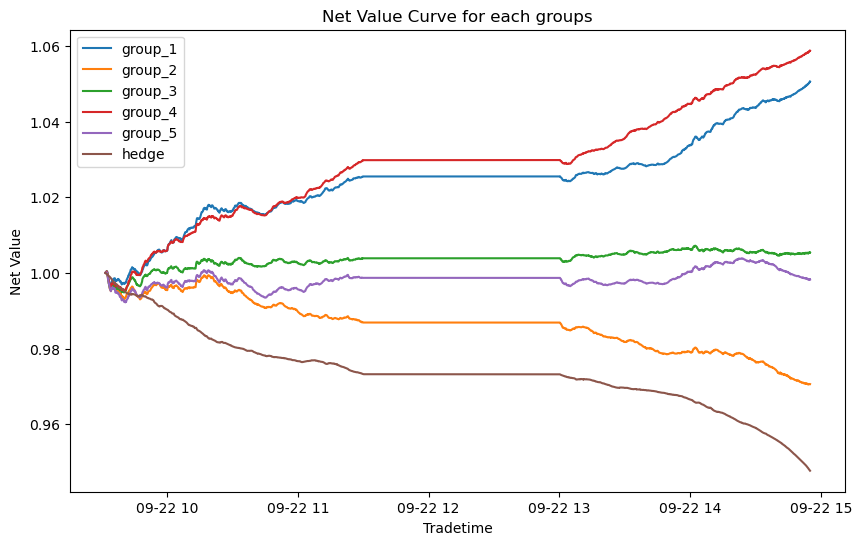

In [19]:
plot_dirpath = f'{base_dirpath}/BTplot'
os.makedirs(plot_dirpath, exist_ok=True)
nv_group_filepath = f"{plot_dirpath}/{factor_name}.png"
plot_quantile_netvalue(port_netvalue_summary, nv_group_filepath)
port_netvalue_summary

In [29]:
names = list(ic_summary_bygroup.index.names)
names[0] = 'Type'
ic_summary_bygroup.index = ic_summary_bygroup.index.rename(names)
ic_summary_bygroup

1m        3m        5m
Type    factor_quantile                              
IC Mean 1                0.042632  0.029070  0.026186
        2               -0.090030 -0.071320 -0.062392
        3                0.035779  0.031591  0.029657
        4                0.114684  0.093502  0.083234
        5               -0.052692 -0.053606 -0.050212
IC Std. 1                0.083101  0.075272  0.072934
        2                0.077972  0.072266  0.071537
        3                0.097391  0.082986  0.075989
        4                0.070258  0.064430  0.062428
        5                0.080355  0.066871  0.065120
ICIR    1                0.513018  0.386200  0.359033
        2               -1.154652 -0.986905 -0.872156
        3                0.367373  0.380681  0.390273
        4                1.632323  1.451223  1.333270
        5               -0.655747 -0.801641 -0.771072

In [30]:
ic_summary_bygroup.loc['IC Mean']

,1m,3m,5m
factor_quantile,,,
1,0.042632,0.029070,0.026186
2,-0.090030,-0.071320,-0.062392
3,0.035779,0.031591,0.029657
4,0.114684,0.093502,0.083234
5,-0.052692,-0.053606,-0.050212


In [24]:
ic_data_bygroup = factor_information_coefficient(factor_and_ret, by_group=True)
ic_summary_bygroup =get_factor_ic_summary_info(ic_data_bygroup, by_group=True)
ic_summary_bygroup

1m        3m        5m
        factor_quantile                              
IC Mean 1                0.042632  0.029070  0.026186
        2               -0.090030 -0.071320 -0.062392
        3                0.035779  0.031591  0.029657
        4                0.114684  0.093502  0.083234
        5               -0.052692 -0.053606 -0.050212
IC Std. 1                0.083101  0.075272  0.072934
        2                0.077972  0.072266  0.071537
        3                0.097391  0.082986  0.075989
        4                0.070258  0.064430  0.062428
        5                0.080355  0.066871  0.065120
ICIR    1                0.513018  0.386200  0.359033
        2               -1.154652 -0.986905 -0.872156
        3                0.367373  0.380681  0.390273
        4                1.632323  1.451223  1.333270
        5               -0.655747 -0.801641 -0.771072

In [67]:
pos['cumret'] = pos.groupby(['securityid', 'tranche'])['ret'].transform(lambda x: np.cumprod(1 + x))
pos['expr'] = pos['cumret'] * pos['wt']
pos['pnl'] = pos['expr'] * pos['ret'] / (1 + pos['ret'])
pos.loc[pos['age']==0, 'pnl'] = 0

In [69]:
pos.head(5)

,tranche,securityid,factor,wt,age,timedelta,tradetime,factor_name,ret,cumret,expr,pnl,tranche_pnl_x,net_value_x,correct_pnl,tranche_pnl_y,net_value_y
0,2023-09-22 09:31:39,000026.SZ,0.181818,0.000962,0,0 days 00:00:00,2023-09-22 09:31:39,haha,-0.000873,0.999127,0.000961,0.000000e+00,0.000019,1.0,0.000000e+00,0.000019,1.0
1,2023-09-22 09:31:39,000026.SZ,0.181818,0.000962,1,0 days 00:00:03,2023-09-22 09:31:42,haha,0.000873,1.000000,0.000962,8.390580e-07,0.000019,1.0,8.390580e-07,0.000019,1.0
2,2023-09-22 09:31:39,000026.SZ,0.181818,0.000962,2,0 days 00:00:06,2023-09-22 09:31:45,haha,0.000000,1.000000,0.000962,0.000000e+00,0.000019,1.0,0.000000e+00,0.000019,1.0
3,2023-09-22 09:31:39,000026.SZ,0.181818,0.000962,3,0 days 00:00:09,2023-09-22 09:31:48,haha,0.000873,1.000873,0.000962,8.390580e-07,0.000019,1.0,8.390580e-07,0.000019,1.0
4,2023-09-22 09:31:39,000026.SZ,0.181818,0.000962,4,0 days 00:00:12,2023-09-22 09:31:51,haha,-0.000872,1.000000,0.000962,-8.390580e-07,0.000019,1.0,-8.390580e-07,0.000019,1.0


In [70]:
tranche_info = pos.groupby('tranche')['pnl'].sum().reset_index().rename(columns={'pnl': 'tranche_pnl'})
tranche_info['net_value'] = (1+tranche_info['tranche_pnl']).shift(20)
tranche_info['net_value'].fillna(1, inplace=True)
pos = pos.merge(tranche_info, on=['tranche'], how='left')
pos['correct_pnl'] = pos['pnl'] * pos['net_value']

In [77]:
from factor_cal.factor_eval.basic_evaluate import calc_portfolio_pnl

In [80]:
a1 = calc_portfolio_pnl(pos, 'group_1')
a2 = calc_portfolio_pnl(pos, 'group_2')

In [85]:
a1_netv = 1+a1['group_1'].cumsum()
a2_netv = 1+a2['group_2'].cumsum()

In [86]:
a1_netv

0     1.000000
1     1.000031
2     1.000053
3     1.000094
4     1.000104
        ...   
63    0.998083
64    0.998067
65    0.998149
66    0.998103
67    0.998090
Name: group_1, Length: 68, dtype: float64

In [87]:
res = a1.merge(a2, how='outer', on='tradetime')

In [32]:
res

NameError: name 'res' is not defined

In [41]:
portforlio_weight = portforlio_weight.loc["2023-09-22 09:31:00":"2023-09-22 09:35:00"]
portforlio_weight

factor        wt
tradetime           securityid                    
2023-09-22 09:31:39 000026.SZ   0.181818  0.000962
                    000158.SZ   0.242424  0.000962
                    000415.SZ   0.030303  0.000962
                    000536.SZ   0.030303  0.000962
                    000969.SZ   0.272727  0.000962
...                                  ...       ...
2023-09-22 09:35:00 688739.SH   0.121212  0.000049
                    688768.SH   0.080808  0.000049
                    688787.SH   0.454545  0.000049
                    688788.SH   0.030928  0.000049
                    688799.SH   0.226804  0.000049

[67642 rows x 2 columns]

In [81]:
import importlib
importlib.reload(evaluate)

<module 'evaluate' from '/home/wangzirui/workspace/CalculateFactor_ByDDBAPI/example/evaluate.py'>

In [65]:
stock_pnl = evaluate.calc_stock_pnl(portforlio_weight, td_ret, holding_time)


UnboundLocalError: local variable 'pos' referenced before assignment

In [64]:
stock_pnl

NameError: name 'stock_pnl' is not defined

In [66]:
portforlio_pnl = evaluate.calc_portfolio_pnl(stock_pnl, 'group_'+str(group_i))
# metric_info = evaluate_pnl(portforlio_pnl)
# metric_summary = pd.concat([metric_summary, metric_info])

In [63]:
portforlio_pnl

NameError: name 'portforlio_pnl' is not defined

In [72]:
metric_info = evaluate.evaluate_pnl(portforlio_pnl, 'group_'+str(group_i))

In [73]:
metric_info

,group,total_ret,mean_ret,std_ret,sharpe_ratio,win_rate,max_draw_down
0,group_1,-0.001788,-0.00109,0.001406,-0.775119,0.176471,0.003781


In [30]:
portforlio_weight

factor        wt
tradetime           securityid                    
2023-09-22 09:31:39 000026.SZ   0.181818  0.000962
                    000158.SZ   0.242424  0.000962
                    000415.SZ   0.030303  0.000962
                    000536.SZ   0.030303  0.000962
                    000969.SZ   0.272727  0.000962
...                                  ...       ...
2023-09-22 14:57:00 688671.SH   0.080000  0.000065
                    688702.SH   0.380000  0.000065
                    688766.SH   0.460000  0.000065
                    688768.SH   0.020000  0.000065
                    688777.SH   0.120000  0.000065

[4758953 rows x 2 columns]

In [64]:
import warnings
import alphalens
import pandas as pd
from scipy import stats
from scipy.stats import ConstantInputWarning
import sys
sys.path.insert(0, "../")
from alphalens import performance as perf
import dolphindb as ddb 

from factor_cal.config_loader import basic_config as cfg
from factor_cal.table.ddb_table import PriceTable, SecLevelFacTable
from factor_cal.utils import ddb_utils as du


# 忽略特定类别的警告
warnings.filterwarnings("ignore", category=ConstantInputWarning)

# read config file
config = cfg.BasicConfig('config/config.yml')
factor_name = "pv_corr"
# obtain the ddb session
s = du.DDBSessionSingleton().session


In [65]:
def get_clean_data(factor_name, date):
    fac_tb = SecLevelFacTable(config['factor_dbPath'], config['factor_tbName'])
    fac = fac_tb.load_factor(factor_name, date, config['start_time'], config['end_time'], sec_list=None)
    
    price_info = config['price_info']
    pc_tb = PriceTable(price_info['price_dbPath'], price_info['price_tbName'], price_info['time_col'], price_info['sec_col'], price_info['price_cols'])
    price = pc_tb.load_price(date, config['start_time'], config['end_time'], sec_list=None)
    
    fac_df = s.loadTable(tableName=fac).toDF()
    if (fac_df.empty):
        return None
    price_df = s.loadTable(tableName=price).toDF()
    
    fac_df = fac_df.set_index(['tradetime', 'securityid'])
    fac_df = fac_df['value']
    fac_df = fac_df.sort_index(level=0)
    
    price_df = price_df.set_index(['tradetime', 'securityid'])
    prices = price_df['close'].unstack()
    
    data=alphalens.utils.get_clean_factor_and_forward_returns(
        fac_df, prices, quantiles=5,periods=(20,60,100))
    return data

In [66]:
data3 = get_clean_data(factor_name, '2023.09.22')


Dropped 30.7% entries from factor data: 30.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [107]:
data3.tail(10)

1m        3m        5m    factor  \
date                asset                                               
2023-09-22 14:55:00 688778.SH  0.000713 -0.001189 -0.001189  0.028065   
                    688779.SH  0.001129  0.001129  0.001129 -0.194700   
                    688788.SH -0.001315 -0.001578 -0.001578  0.218218   
                    688789.SH  0.000659  0.000000  0.000000  0.079354   
                    688798.SH  0.000435  0.002322  0.002322  0.068970   
                    688799.SH  0.001240  0.001240  0.001240 -0.316630   
                    688800.SH  0.000000 -0.000509 -0.000509 -0.509175   
                    688819.SH  0.000286  0.000859  0.000859  0.171618   
                    688981.SH  0.000000  0.000586  0.000586 -0.699929   
                    689009.SH  0.000856  0.000571  0.000571  0.271901   

                               factor_quantile  
date                asset                       
2023-09-22 14:55:00 688778.SH                3  
                    688779.SH                2  
                    688788.SH                4  
                    688789.SH                3  
                    688798.SH                3  
                    688799.SH                2  
                    688800.SH                1  
                    688819.SH                4  
                    688981.SH                1  
                    689009.SH                4

In [74]:
data = data3.rename(columns={'factor_quantile':'group'})
data

1m        3m        5m    factor  group
date                asset                                                   
2023-09-22 09:30:12 000002.SZ  0.000755 -0.002264 -0.002264  0.714826      5
                    000004.SZ  0.005518 -0.006131 -0.006744 -0.199991      2
                    000006.SZ -0.004367 -0.002183 -0.002183 -0.985586      1
                    000010.SZ -0.006061  0.012121  0.015152 -0.011458      3
                    000026.SZ  0.003506 -0.001753 -0.001753 -0.776636      1
...                                 ...       ...       ...       ...    ...
2023-09-22 14:55:00 688799.SH  0.001240  0.001240  0.001240 -0.316630      2
                    688800.SH  0.000000 -0.000509 -0.000509 -0.509175      1
                    688819.SH  0.000286  0.000859  0.000859  0.171618      4
                    688981.SH  0.000000  0.000586  0.000586 -0.699929      1
                    689009.SH  0.000856  0.000571  0.000571  0.271901      4

[16827626 rows x 5 columns]

In [77]:
alphalens.performance.factor_information_coefficient(data, by_group=False)

,1m,3m,5m
date,,,
2023-09-22 09:30:12,-0.032108,-0.033521,-0.018338
2023-09-22 09:30:15,0.009120,-0.020407,-0.005716
2023-09-22 09:30:18,0.002658,0.004670,0.010197
2023-09-22 09:30:21,0.009715,0.022710,0.024852
2023-09-22 09:30:24,0.027744,0.046368,0.044983
...,...,...,...
2023-09-22 14:54:48,0.000049,-0.017524,-0.017524
2023-09-22 14:54:51,0.001268,-0.019766,-0.019766
2023-09-22 14:54:54,-0.014018,-0.014151,-0.014151


In [81]:
data

1m        3m        5m    factor  group
date                asset                                                   
2023-09-22 09:30:12 000002.SZ  0.000755 -0.002264 -0.002264  0.714826      5
                    000004.SZ  0.005518 -0.006131 -0.006744 -0.199991      2
                    000006.SZ -0.004367 -0.002183 -0.002183 -0.985586      1
                    000010.SZ -0.006061  0.012121  0.015152 -0.011458      3
                    000026.SZ  0.003506 -0.001753 -0.001753 -0.776636      1
...                                 ...       ...       ...       ...    ...
2023-09-22 14:55:00 688799.SH  0.001240  0.001240  0.001240 -0.316630      2
                    688800.SH  0.000000 -0.000509 -0.000509 -0.509175      1
                    688819.SH  0.000286  0.000859  0.000859  0.171618      4
                    688981.SH  0.000000  0.000586  0.000586 -0.699929      1
                    689009.SH  0.000856  0.000571  0.000571  0.271901      4

[16827626 rows x 5 columns]

In [89]:
tmp_data = data[:10000]
grouper = [tmp_data.index.get_level_values('date')]
grouper.append('group')
tmp_data.groupby(grouper).apply(lambda x: print("xixi", x))

xixi                                      1m        3m        5m    factor  group
date                asset                                                   
2023-09-22 09:30:12 000006.SZ -0.004367 -0.002183 -0.002183 -0.985586      1
                    000026.SZ  0.003506 -0.001753 -0.001753 -0.776636      1
                    000506.SZ -0.008214 -0.008214 -0.012320 -0.666927      1
                    000584.SZ -0.004264  0.006397  0.014925 -0.468153      1
                    000637.SZ  0.002558 -0.007673  0.000000 -0.839929      1
                    000650.SZ  0.002903 -0.004354 -0.007257 -0.718229      1
                    000826.SZ -0.005479 -0.024658 -0.016438 -0.561431      1
                    001311.SZ  0.000198  0.001191 -0.001191 -0.440686      1
                    002038.SZ -0.003247 -0.008658 -0.011905 -0.432917      1
                    002050.SZ -0.001816 -0.000363  0.000363 -0.722081      1
                    002262.SZ -0.022214 -0.043688 -0.045909 -0.638083  

""


In [99]:
def myfunc(x):
    return x.mean()

In [106]:
# ic_quantile_summary = result.groupby(result.index.get_level_values('group')).apply(lambda x: myfunc(x))
ic_quantile_summary = result.groupby(result.index.get_level_values('group')).agg('mean')
ic_quantile_summary

,1m,3m,5m
group,,,
1,0.005821,0.003325,0.001434
2,0.002137,-0.000060,-0.000023
3,-0.021638,-0.019840,-0.016788
4,0.003562,0.000090,0.000033
5,0.014902,0.008498,0.006812


<Axes: title={'center': 'Mean Period Wise Return By Factor Quantile'}, ylabel='Mean Return (bps)'>

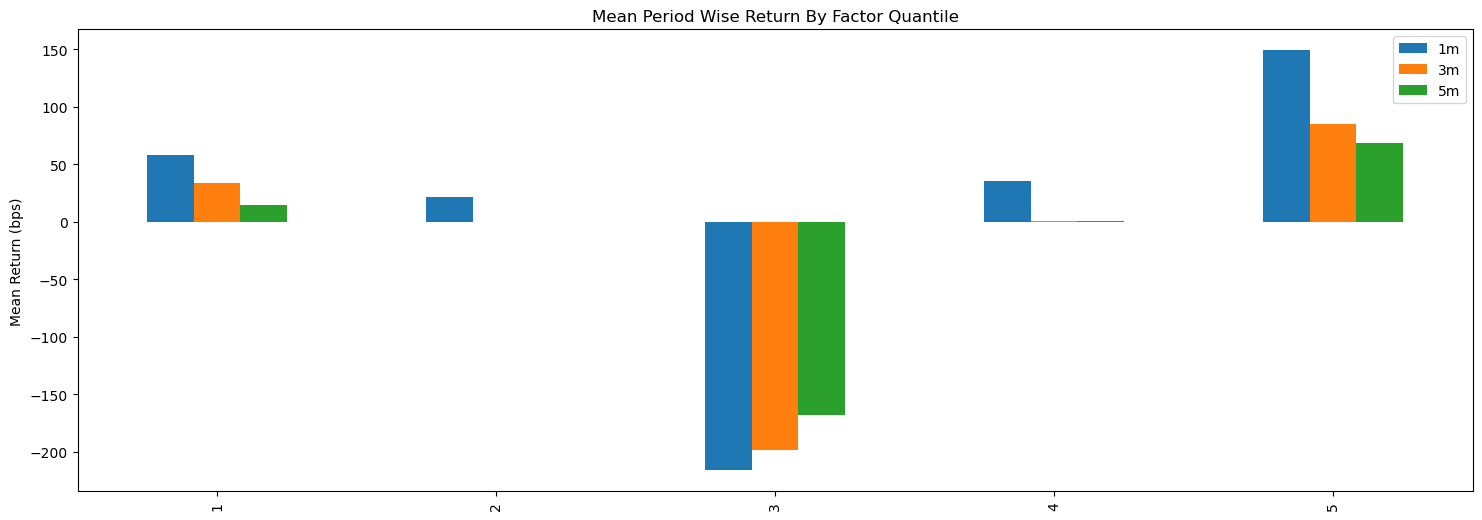

In [103]:
alphalens.plotting.plot_quantile_returns_bar(ic_quantile_summary)

In [94]:
result = alphalens.performance.factor_information_coefficient(data, by_group=True)

In [76]:
data.index.get_level_values('date')

DatetimeIndex(['2023-09-22 09:30:12', '2023-09-22 09:30:12',
               '2023-09-22 09:30:12', '2023-09-22 09:30:12',
               '2023-09-22 09:30:12', '2023-09-22 09:30:12',
               '2023-09-22 09:30:12', '2023-09-22 09:30:12',
               '2023-09-22 09:30:12', '2023-09-22 09:30:12',
               ...
               '2023-09-22 14:55:00', '2023-09-22 14:55:00',
               '2023-09-22 14:55:00', '2023-09-22 14:55:00',
               '2023-09-22 14:55:00', '2023-09-22 14:55:00',
               '2023-09-22 14:55:00', '2023-09-22 14:55:00',
               '2023-09-22 14:55:00', '2023-09-22 14:55:00'],
              dtype='datetime64[ns]', name='date', length=16827626, freq=None)

In [ ]:
date1 = '2023.09.22'
date2 = '2024.02.07'
data1 = get_clean_data(factor_name, date1)


/home/wangzirui/miniconda3/envs/py38/lib/python3.8/site-packages/alphalens/utils.py:158: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(index=x.index)


Dropped 9.2% entries from factor data: 8.4% in forward returns computation and 0.9% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [ ]:
data1

1m        3m        5m    factor  \
date                asset                                               
2023-09-22 09:45:00 000002.SZ -0.000755  0.000000  0.000000 -0.003759   
                    000004.SZ  0.005611  0.000000 -0.002494 -0.018960   
                    000006.SZ -0.002174 -0.002174  0.002174  0.004367   
                    000010.SZ -0.006006 -0.009009 -0.012012  0.000000   
                    000026.SZ  0.000000  0.002636  0.003515 -0.006981   
...                                 ...       ...       ...       ...   
2023-09-22 14:55:00 688799.SH  0.001240  0.001240  0.001240 -0.006652   
                    688800.SH  0.000000 -0.000509 -0.000509 -0.001272   
                    688819.SH  0.000286  0.000859  0.000859  0.003448   
                    688981.SH  0.000000  0.000586  0.000586 -0.000975   
                    689009.SH  0.000856  0.000571  0.000571  0.000571   

                               factor_quantile  
date                asset                       
2023-09-22 09:45:00 000002.SZ              2.0  
                    000004.SZ              1.0  
                    000006.SZ              3.0  
                    000010.SZ              3.0  
                    000026.SZ              2.0  
...                                        ...  
2023-09-22 14:55:00 688799.SH              1.0  
                    688800.SH              1.0  
                    688819.SH              5.0  
                    688981.SH              1.0  
                    689009.SH              3.0  

[22051635 rows x 5 columns]

In [ ]:
data2 = get_clean_data(factor_name, date2)

/home/wangzirui/miniconda3/envs/py38/lib/python3.8/site-packages/alphalens/utils.py:158: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(index=x.index)


Dropped 8.4% entries from factor data: 8.4% in forward returns computation and 0.1% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [ ]:
data = pd.concat([data1, data2], axis=0)

In [68]:
group_neutral = False
ic_data = perf.factor_information_coefficient(data3, group_neutral)

In [69]:

group_neutral = False
ic_data = perf.factor_information_coefficient(data, group_neutral)


ic_summary_table = pd.DataFrame()
ic_summary_table["IC Mean"] = ic_data.mean()
ic_summary_table["IC Std."] = ic_data.std()
ic_summary_table["Risk-Adjusted IC"] = \
    ic_data.mean() / ic_data.std()
t_stat, p_value = stats.ttest_1samp(ic_data, 0, nan_policy='omit')
ic_summary_table["t-stat(IC)"] = t_stat
ic_summary_table["p-value(IC)"] = p_value
ic_summary_table["IC Skew"] = stats.skew(ic_data, nan_policy='omit')
ic_summary_table["IC Kurtosis"] = stats.kurtosis(ic_data, nan_policy='omit')
ic_summary_table['IC win rate'] = (ic_data > 0).sum() / ic_data.count()

NameError: name 'data' is not defined

In [ ]:
ic_summary_table

,IC Mean,IC Std.,Risk-Adjusted IC,t-stat(IC),p-value(IC),IC Skew,IC Kurtosis,IC win rate
1m,-0.094709,0.099195,-0.954777,-89.357090,0.0,0.434262,0.388191,0.168512
3m,-0.085754,0.127504,-0.672560,-62.944589,0.0,0.284041,0.030687,0.243407
5m,-0.071779,0.137860,-0.520664,-48.728696,0.0,0.167942,-0.102550,0.301861


In [ ]:
save_path = '/home/wangzirui/workspace/factor_ic_summary'
ic_summary_table.to_pickle(f'{save_path}/{factor_name}.pkl')

In [ ]:
result = pd.read_pickle(f'{save_path}/{factor_name}.pkl')

In [ ]:
result

,IC Mean,IC Std.,Risk-Adjusted IC,t-stat(IC),p-value(IC),IC Skew,IC Kurtosis,IC win rate
1m,-0.110157,0.095285,-1.156078,-254.026932,0.0,0.799751,2.929081,0.108322
3m,-0.116683,0.134783,-0.865706,-190.222987,0.0,0.694428,2.763240,0.153867
5m,-0.111498,0.148553,-0.750564,-164.922682,0.0,0.741072,2.938257,0.180668


In [ ]:
mean_return, std_return = alphalens.performance.mean_return_by_quantile(data3, by_group=False, demeaned=True)
mean_return

,1m,3m,5m
factor_quantile,,,
1,0.000022,0.000039,0.000040
2,0.000057,0.000066,0.000064
3,-0.000004,-0.000005,-0.000004
4,-0.000065,-0.000074,-0.000075
5,-0.000010,-0.000026,-0.000025


In [ ]:
mean_rateret = mean_return.apply(alphalens.utils.rate_of_return, axis=0,
                             base_period=mean_return.columns[0])
mean_rateret

,1m,3m,5m
factor_quantile,,,
1,0.000022,0.000013,8.013858e-06
2,0.000057,0.000022,1.280173e-05
3,-0.000004,-0.000002,-7.361735e-07
4,-0.000065,-0.000025,-1.509348e-05
5,-0.000010,-0.000009,-4.990858e-06


In [ ]:
mean_return_bydate, std_return_bydate = alphalens.performance.mean_return_by_quantile(data3, by_date=True)
mean_return_bydate.loc[1]#, std_return_bydate.loc[1]

,1m,3m,5m
date,,,
2023-09-22 09:30:12,-0.000125,-0.000035,0.000261
2023-09-22 09:30:15,0.000050,0.000389,0.000437
2023-09-22 09:30:18,0.000081,0.000229,0.000156
2023-09-22 09:30:21,-0.000050,-0.000038,-0.000147
2023-09-22 09:30:24,-0.000030,-0.000124,-0.000167
...,...,...,...
2023-09-22 14:54:48,-0.000026,-0.000041,-0.000041
2023-09-22 14:54:51,0.000054,0.000059,0.000059
2023-09-22 14:54:54,0.000117,0.000073,0.000073


In [ ]:
compstd_quant_daily = std_return_bydate.apply(
        alphalens.utils.std_conversion, axis=0,
        base_period=std_return_bydate.columns[0]
    )
compstd_quant_daily

1m        3m        5m
factor_quantile date                                             
1               2023-09-22 09:30:12  0.001035  0.001031  0.000970
                2023-09-22 09:30:15  0.000158  0.000150  0.000141
                2023-09-22 09:30:18  0.000143  0.000137  0.000134
                2023-09-22 09:30:21  0.000142  0.000127  0.000122
                2023-09-22 09:30:24  0.000138  0.000121  0.000113
...                                       ...       ...       ...
5               2023-09-22 14:54:48  0.000047  0.000034  0.000027
                2023-09-22 14:54:51  0.000044  0.000032  0.000025
                2023-09-22 14:54:54  0.000044  0.000033  0.000025
                2023-09-22 14:54:57  0.000041  0.000032  0.000025
                2023-09-22 14:55:00  0.000043  0.000032  0.000025

[23490 rows x 3 columns]

In [71]:
data3

1m        3m        5m    factor  \
date                asset                                               
2023-09-22 09:30:12 000002.SZ  0.000755 -0.002264 -0.002264  0.714826   
                    000004.SZ  0.005518 -0.006131 -0.006744 -0.199991   
                    000006.SZ -0.004367 -0.002183 -0.002183 -0.985586   
                    000010.SZ -0.006061  0.012121  0.015152 -0.011458   
                    000026.SZ  0.003506 -0.001753 -0.001753 -0.776636   
...                                 ...       ...       ...       ...   
2023-09-22 14:55:00 688799.SH  0.001240  0.001240  0.001240 -0.316630   
                    688800.SH  0.000000 -0.000509 -0.000509 -0.509175   
                    688819.SH  0.000286  0.000859  0.000859  0.171618   
                    688981.SH  0.000000  0.000586  0.000586 -0.699929   
                    689009.SH  0.000856  0.000571  0.000571  0.271901   

                               factor_quantile  
date                asset                       
2023-09-22 09:30:12 000002.SZ                5  
                    000004.SZ                2  
                    000006.SZ                1  
                    000010.SZ                3  
                    000026.SZ                1  
...                                        ...  
2023-09-22 14:55:00 688799.SH                2  
                    688800.SH                1  
                    688819.SH                4  
                    688981.SH                1  
                    689009.SH                4  

[16827626 rows x 5 columns]

In [70]:
alphalens.plotting.plot_quantile_statistics_table(data3)

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-1.000001,-0.098043,-0.579123,0.186180,3367384,20.011046
2,-0.621542,0.187108,-0.236162,0.079383,3364631,19.994686
3,-0.363069,0.421224,-0.006747,0.092259,3364658,19.994847
4,-0.142718,0.806087,0.221046,0.078905,3364465,19.993700
5,0.155149,1.000001,0.555791,0.187009,3366488,20.005722


In [ ]:
mean_ret_spread_quant, std_spread_quant = alphalens.performance.compute_mean_returns_spread(
        mean_return_bydate,
        data3['factor_quantile'].max(),
        data3['factor_quantile'].min(),
        std_err=compstd_quant_daily)

In [ ]:
fr_cols = 1
vertical_sections = 2 + fr_cols * 3
gf = alphalens.tears.GridFigure(rows=1, cols=1)

<Figure size 1400x700 with 0 Axes>

In [ ]:
mean_rateret

In [63]:
alphalens.plotting.plot_quantile_returns_bar(mean_rateret,
                                       by_group=False,
                                       ylim_percentiles=None,
                                       ax=gf.next_row())

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
ic=perf.factor_information_coefficient(data3, group_neutral)

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-1.000001,-0.098043,-0.579123,0.186180,3367384,20.011046
2,-0.621542,0.187108,-0.236162,0.079383,3364631,19.994686
3,-0.363069,0.421224,-0.006747,0.092259,3364658,19.994847
4,-0.142718,0.806087,0.221046,0.078905,3364465,19.993700
5,0.155149,1.000001,0.555791,0.187009,3366488,20.005722


Returns Analysis


/home/wangzirui/miniconda3/envs/py38/lib/python3.8/site-packages/alphalens/plotting.py:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns_table = returns_table.append(alpha_beta)


,1m,3m,5m
Ann. alpha,-1.000,-0.992,-0.962
beta,0.004,-0.002,0.009
Mean Period Wise Return Top Quantile (bps),-0.097,-0.087,-0.050
Mean Period Wise Return Bottom Quantile (bps),0.217,0.130,0.080
Mean Period Wise Spread (bps),-0.314,-0.217,-0.130


/home/wangzirui/miniconda3/envs/py38/lib/python3.8/site-packages/alphalens/tears.py:256: UserWarning: 'freq' not set in factor_data index: assuming business day
  warnings.warn(
/home/wangzirui/miniconda3/envs/py38/lib/python3.8/site-packages/alphalens/performance.py:425: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  i = trades_idx.get_loc(next, method='bfill')
/home/wangzirui/miniconda3/envs/py38/lib/python3.8/site-packages/alphalens/performance.py:478: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  portfolio = pd.Series(index=sub_portfolios.index)
/home/wangzirui/miniconda3/envs/py38/lib/python3.8/site-packages/alphalens/performance.py:425: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_in

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/wangzirui/miniconda3/envs/py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3299049/1331283715.py", line 1, in <module>
    alphalens.tears.create_full_tear_sheet(data3)
  File "/home/wangzirui/miniconda3/envs/py38/lib/python3.8/site-packages/alphalens/plotting.py", line 45, in call_w_context
    return func(*args, **kwargs)
  File "/home/wangzirui/miniconda3/envs/py38/lib/python3.8/site-packages/alphalens/tears.py", line 481, in create_full_tear_sheet
    create_returns_tear_sheet(factor_data,
  File "/home/wangzirui/miniconda3/envs/py38/lib/python3.8/site-packages/alphalens/plotting.py", line 47, in call_w_context
    return func(*args, **kwargs)
  File "/home/wangzirui/miniconda3/envs/py38/lib/python3.8/site-packages/alphalens/tears.py", line 276, in create_returns_tear_sheet
    plotting.plot_cumulative_returns_by_qua

<Figure size 640x480 with 0 Axes>

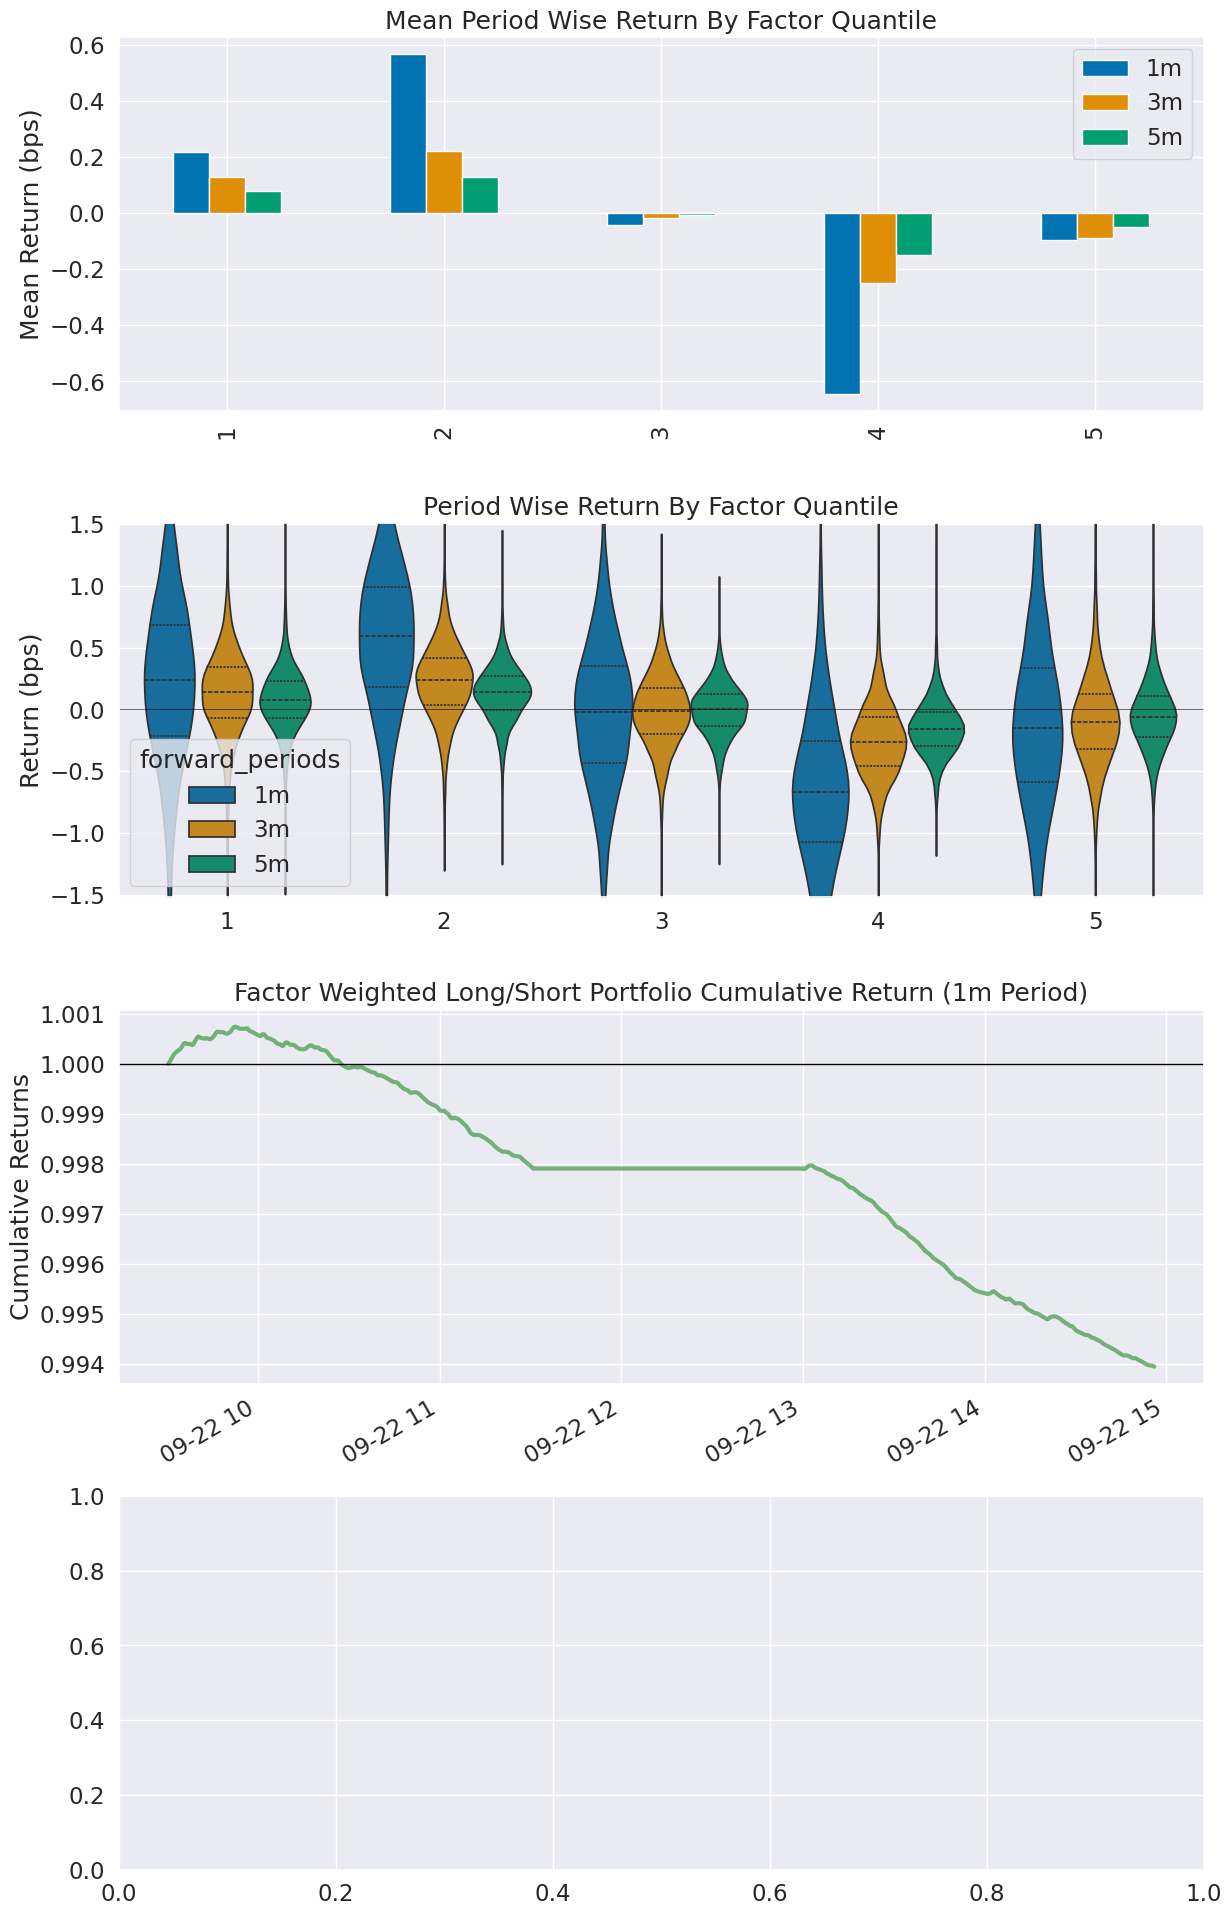

In [ ]:
alphalens.tears.create_full_tear_sheet(data3)

In [ ]:
# Information Analysis
ic = perf.factor_information_coefficient(data3)
alphalens.plotting.plot_information_table(ic)

Information Analysis


,1m,3m,5m
IC Mean,-0.022,-0.027,-0.025
IC Std.,0.031,0.032,0.033
Risk-Adjusted IC,-0.708,-0.851,-0.758
t-stat(IC),-48.537,-58.352,-51.952
p-value(IC),0.000,0.000,0.000
IC Skew,0.073,0.303,0.291
IC Kurtosis,0.421,0.653,0.820


In [ ]:
alphalens.plotting.plot_cumulative_returns_by_quantile(mean_return, '1D')

TypeError: plot_cumulative_returns_by_quantile() missing 1 required positional argument: 'freq'

In [ ]:

fac_tb = SecLevelFacTable(config['factor_dbPath'], config['factor_tbName'])
fac = fac_tb.load_factor(factor_name, "2023.09.22", config['start_time'], config['end_time'], sec_list=None)

In [ ]:
price_info = config['price_info']
pc_tb = PriceTable(price_info['price_dbPath'], price_info['price_tbName'], price_info['time_col'], price_info['sec_col'], price_info['price_cols'])
price = pc_tb.load_price("2023.09.22", config['start_time'], config['end_time'], sec_list=None)

In [ ]:
price_df = s.loadTable(tableName=price).toDF()
fac_df = s.loadTable(tableName=fac).toDF()

In [ ]:
fac_df = fac_df.set_index(['tradetime', 'securityid'])
fac_df = fac_df['value']
fac_df = fac_df.sort_index(level=0)

In [ ]:
price_df = price_df.set_index(['tradetime', 'securityid'])
prices = price_df['close'].unstack()

In [ ]:
start_time = pd.to_datetime('9:45').time()
end_time = pd.to_datetime('14:30').time()

prices = prices.between_time(start_time, end_time)

In [ ]:
start_time = pd.to_datetime('9:45').time()
end_time = pd.to_datetime('13:30').time()

test_df = fac_df.reset_index().set_index('tradetime').between_time(start_time, end_time)
test_df.reset_index(inplace=True)
test_df.set_index(['tradetime','securityid'], inplace=True)
# selected_data = fac_df.between_time(start_time, end_time)

value
tradetime           securityid          
2023-09-22 09:45:00 000001.SZ        NaN
                    000002.SZ   0.278530
                    000004.SZ   0.284619
                    000005.SZ  -0.152224
                    000006.SZ        NaN
...                                  ...
2023-09-22 13:30:00 688799.SH   0.243225
                    688800.SH        NaN
                    688819.SH  -0.666667
                    688981.SH   0.065909
                    689009.SH   0.395312

[13669418 rows x 1 columns]

In [ ]:
fac_df.index.get_label.between_time(start_time, end_time)

TypeError: Index must be DatetimeIndex

In [ ]:
fac_df.isna().sum(), (~fac_df.isna()).sum()

(7240881, 17052437)

In [ ]:
fac_df.loc[pd.to_datetime('2023-09-22 09:45:03')]

securityid
000001.SZ         NaN
000002.SZ    0.266224
000004.SZ    0.268894
000005.SZ   -0.109348
000006.SZ         NaN
               ...   
688799.SH   -0.279244
688800.SH   -0.377793
688819.SH    0.605374
688981.SH   -0.592932
689009.SH         NaN
Name: value, Length: 5059, dtype: float64

In [ ]:
import alphalens

data=alphalens.utils.get_clean_factor_and_forward_returns(
    fac_df, prices, quantiles=5,periods=(20,60,100))

# alphalens.utils.get_clean_factor_and_forward_returns(fac_df, 
#     prices, 
#     quantiles=None,
#     bins=1,
#     periods=(1, 2, 3, 4, 5, 6, 10),
#     filter_zscore=None)


/home/wangzirui/miniconda3/envs/py38/lib/python3.8/site-packages/alphalens/utils.py:158: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(index=x.index)


Dropped 9.2% entries from factor data: 8.4% in forward returns computation and 0.9% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [ ]:
prices.loc[[pd.to_datetime('2023-09-22 11:30:00'), pd.to_datetime('2023-09-22 13:00:00'), pd.to_datetime('2023-09-22 13:01:00')]]

securityid,000001.SZ,000002.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,...,688787.SH,688788.SH,688789.SH,688793.SH,688798.SH,688799.SH,688800.SH,688819.SH,688981.SH,689009.SH
tradetime,,,,,,,,,,,,,,,,,,,,,
2023-09-22 11:30:00,11.14,13.29,16.260000,1.47,4.62,4.51,2.42,10.23,3.29,9.81,...,71.940002,37.369999,88.510002,35.720001,68.669998,40.009998,39.049999,34.419998,50.470001,34.799999
2023-09-22 13:00:00,11.14,13.30,16.260000,1.47,4.62,4.51,2.42,10.23,3.29,9.81,...,71.940002,37.369999,88.510002,35.720001,68.669998,40.009998,39.049999,34.419998,50.490002,34.799999
2023-09-22 13:01:00,11.13,13.28,16.290001,1.46,4.62,4.51,2.42,10.21,3.29,9.80,...,71.610001,37.389999,88.690002,35.730000,68.610001,39.930000,38.880001,34.400002,50.480000,34.849998


In [ ]:
13.28/13.29-1

-0.0007524454477050302

In [ ]:
data.loc[pd.to_datetime('2023-09-22 11:30:00')]

,1m,3m,5m,factor,factor_quantile
asset,,,,,
000001.SZ,-0.000898,-0.000898,-0.000898,0.001799,3.0
000002.SZ,-0.000752,-0.001505,-0.000752,0.003019,4.0
000004.SZ,0.001845,0.002460,0.003075,0.000615,2.0
000005.SZ,-0.006803,-0.013605,-0.013605,0.006849,5.0
000006.SZ,0.000000,0.000000,0.000000,0.000000,2.0
...,...,...,...,...,...
688799.SH,-0.001999,-0.003749,-0.002999,0.003763,4.0
688800.SH,-0.004353,-0.006914,-0.008963,0.006962,5.0
688819.SH,-0.000581,-0.001162,-0.002034,-0.000581,1.0


In [ ]:
prices.loc[pd.to_datetime('2023-09-22 11:29:57'):pd.to_datetime('2023-09-22 13:00:10')]

In [ ]:
import pandas as pd
# data.loc[pd.to_datetime('2023-09-22 11:29:57')]
data.loc[pd.to_datetime('2023-09-22 11:30:03'):pd.to_datetime('2023-09-22 11:30:30')]

In [ ]:
from alphalens import performance as perf
group_neutral = False
ic_data = perf.factor_information_coefficient(data, group_neutral)

import pandas as pd 
from scipy import stats
ic_summary_table = pd.DataFrame()
ic_summary_table["IC Mean"] = ic_data.mean()
ic_summary_table["IC Std."] = ic_data.std()
ic_summary_table["Risk-Adjusted IC"] = \
    ic_data.mean() / ic_data.std()
t_stat, p_value = stats.ttest_1samp(ic_data, 0, nan_policy='omit')
ic_summary_table["t-stat(IC)"] = t_stat
ic_summary_table["p-value(IC)"] = p_value
ic_summary_table["IC Skew"] = stats.skew(ic_data, nan_policy='omit')
ic_summary_table["IC Kurtosis"] = stats.kurtosis(ic_data, nan_policy='omit')
ic_summary_table['IC win rate'] = (ic_data > 0).sum() / ic_data.count()

In [ ]:
ic_summary_table

In [ ]:
alphalens.tears.create_returns_tear_sheet(data, long_short=True, group_neutral=False, by_group=False)

In [ ]:
alphalens.tears.create_information_tear_sheet(data, group_neutral=False, by_group=False)

In [ ]:
alphalens.tears.create_turnover_tear_sheet(data)

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-1.000001,-0.098043,-0.579123,0.186180,3367384,20.011046
2,-0.621542,0.187108,-0.236162,0.079383,3364631,19.994686
3,-0.363069,0.421224,-0.006747,0.092259,3364658,19.994847
4,-0.142718,0.806087,0.221046,0.078905,3364465,19.993700
5,0.155149,1.000001,0.555791,0.187009,3366488,20.005722


Returns Analysis


/home/wangzirui/miniconda3/envs/py38/lib/python3.8/site-packages/alphalens/plotting.py:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  returns_table = returns_table.append(alpha_beta)


,1m,3m,5m
Ann. alpha,-1.000,-0.992,-0.962
beta,0.004,-0.002,0.009
Mean Period Wise Return Top Quantile (bps),-0.097,-0.087,-0.050
Mean Period Wise Return Bottom Quantile (bps),0.217,0.130,0.080
Mean Period Wise Spread (bps),-0.314,-0.217,-0.130


Information Analysis


,1m,3m,5m
IC Mean,-0.022,-0.027,-0.025
IC Std.,0.031,0.032,0.033
Risk-Adjusted IC,-0.708,-0.851,-0.758
t-stat(IC),-48.537,-58.352,-51.952
p-value(IC),0.000,0.000,0.000
IC Skew,0.073,0.303,0.291
IC Kurtosis,0.421,0.653,0.820


ValueError: freq must be Day, BDay or CustomBusinessDay

<Figure size 640x480 with 0 Axes>

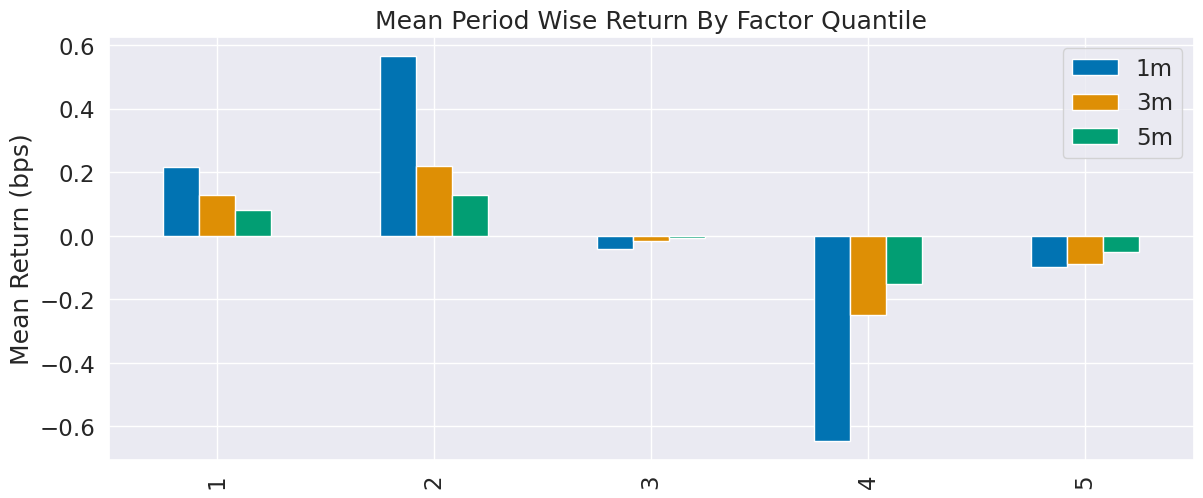

In [ ]:
alphalens.tears.create_summary_tear_sheet(data3)

In [ ]:
import re

def parse_function_call(s):
    def parse_args(s):
        args = []
        balance = 0
        current_arg = []
        for char in s:
            if char == ',' and balance == 0:
                args.append(''.join(current_arg).strip())
                current_arg = []
            else:
                if char == '(':
                    balance += 1
                elif char == ')':
                    balance -= 1
                current_arg.append(char)
        if current_arg:
            args.append(''.join(current_arg).strip())
        return args

    match = re.match(r'(\w+)\((.*)\)', s)
    if match:
        func_name = match.group(1)
        args_str = match.group(2)
        args = parse_args(args_str)
        args = [parse_function_call(arg) for arg in args]
        parsed_args = []
        parsed_kwargs = {}
        for arg in args:
            if isinstance(arg, dict):
                parsed_args.append(arg)
            elif isinstance(arg, str):
                arg = arg.strip()
                if "=" in arg:
                    parsed_kwargs[arg.split("=")[0].strip()] = arg.split("=")[1].strip()
                else:
                    parsed_args.append(arg)
        return {'function': func_name, 'args': parsed_args, 'kwargs': parsed_kwargs}
    else:
        return s

# 示例
input_str = "corr(add(x,mul(x,y)),z, window=1)"
parsed_result = parse_function_call(input_str)
print(parsed_result)

{'function': 'corr', 'args': [{'function': 'add', 'args': ['x', {'function': 'mul', 'args': ['x', 'y'], 'kwargs': {}}], 'kwargs': {}}, 'z'], 'kwargs': {'window': '1'}}


In [ ]:
def rank_pct(arr):
    sorter = np.argsort(arr)
    inv_sorter = np.argsort(sorter)
    ranks = np.arange(1, len(arr) + 1)
    pct_ranks = ranks[inv_sorter] / len(arr)
    return pct_ranks

# 示例
data = np.array([50, 30, 20, 40, 10])
result = rank_pct(data)
print(result)

In [ ]:
import numpy as np
def rank_pct(arr):
    sorter = np.argsort(arr)
    inv_sorter = np.argsort(sorter)
    ranks = np.arange(1, len(arr) + 1)
    pct_ranks = ranks[inv_sorter] / len(arr)
    return pct_ranks

# 示例


In [ ]:
sorter = np.argsort(data)
inv_sorter = np.argsort(sorter)
ranks = np.arange(1, len(arr) + 1)
pct_ranks = ranks[inv_sorter] / len(arr)

array([[4, 3, 1, 2, 0],
       [0, 2, 1, 3, 4]])

In [ ]:
data = np.array([[50, 30, 20, 20, 10], [1,np.nan,2,4,5]])
sorter = np.argsort(data)
inv_sorter = np.argsort(sorter)
# result = rank_pct(data)
# print(result)
np.count_nonzero(~np.isnan(data), axis=1)

array([5, 4])

In [ ]:
ranks = [np.arange(1, i+1) for i in np.count_nonzero(~np.isnan(data), axis=1)]
ranks

[array([1, 2, 3, 4, 5]), array([1, 2, 3, 4])]

In [ ]:
arr = np.array([[1,2,3,4,5], [3,12,3,1,1]])
arr_df = pd.DataFrame(arr.T)
import time
start = time.time()
for i in range(100000):
    arr_df.rolling(window=3).mean(numeric_only=True, engine='numba')
print(time.time()-start)

start = time.time()
for i in range(100000):
    arr_df.rolling(window=3).mean()
print(time.time()-start)

5.013756990432739
8.345810651779175


In [ ]:
np.count_nonzero(np.isnan(np.array([[np.nan, 1, 2], [3, np.nan, np.nan]])), axis=0)

array([1, 1, 1])

In [ ]:
import numpy as np
import pandas as pd
a = np.array([[np.nan, 1, 2], [3, np.nan, np.nan], [2,3,4]])
a = pd.DataFrame(a)

a.ffill()

,0,1,2
0,NaN,1.0,2.0
1,3.0,1.0,2.0
2,2.0,3.0,4.0


In [42]:
from itertools import product
a = [
    ['window', [1,2,3,4]],
    ['slide', [3,4]],
    ['window', [3, 5]]
]

In [48]:
params_names = [i[0] for i in a]
params_values = [i[1] for i in a]


In [49]:
for params_comb in product(*params_values):
    kwargs_list = []
    for index, value in enumerate(params_comb):
        kwargs_list.append([params_names[index], value])
    print(kwargs_list)

[['window', 1], ['slide', 3], ['window', 3]]
[['window', 1], ['slide', 3], ['window', 5]]
[['window', 1], ['slide', 4], ['window', 3]]
[['window', 1], ['slide', 4], ['window', 5]]
[['window', 2], ['slide', 3], ['window', 3]]
[['window', 2], ['slide', 3], ['window', 5]]
[['window', 2], ['slide', 4], ['window', 3]]
[['window', 2], ['slide', 4], ['window', 5]]
[['window', 3], ['slide', 3], ['window', 3]]
[['window', 3], ['slide', 3], ['window', 5]]
[['window', 3], ['slide', 4], ['window', 3]]
[['window', 3], ['slide', 4], ['window', 5]]
[['window', 4], ['slide', 3], ['window', 3]]
[['window', 4], ['slide', 3], ['window', 5]]
[['window', 4], ['slide', 4], ['window', 3]]
[['window', 4], ['slide', 4], ['window', 5]]


In [52]:
def myfunc(a):
    a.remove(1)
    return a

m = [1,2,3]
print(m)
myfunc(m)
print(m)

[1, 2, 3]
[2, 3]


In [ ]:
[
    {'par1': [], 'par2': []}, 
    [
        [{'par1': [], 'par2':[]}, 
        {'par1': []}
    ]
]

In [65]:
from copy import deepcopy
a = [
    [
        'window', [1,3],
        'slide', [1,5]   
    ],
    [
        'window', [6, 10]
    ],
    [
        'window', [3, 5]
    ]
]

In [66]:
params_list = []
for i in a:
    for key, value in i.items():
        params_list.append(value)
params_list

[[1, 3], [1, 5], [6, 10], [3, 5]]